<div align='left' style="width:38%;overflow:hidden;">
<a href='http://inria.fr'>
<img src='https://github.com/lmarti/jupyter_custom/raw/master/imgs/inr_logo_rouge.png' alt='Inria logo' title='Inria'/>
</a>
</div>

# Machine Learning with `scikit-learn`

# 2. Linear Regression

## by [Nayat Sánchez Pi](http://www.nayatsanchezpi.com) and [Luis Martí](http://lmarti.com)

$\renewcommand{\vec}[1]{\boldsymbol{#1}}$

### About the notebook/slides

* The slides are _programmed_ as a [Jupyter](http://jupyter.org)/[IPython](https://ipython.org/) notebook.
* **Feel free to try them and experiment on your own by launching the notebooks.**

If you are using [nbviewer](http://nbviewer.jupyter.org) you can change to slides mode by clicking on the icon:

<div class="container-fluid">
  <div class="row">
      <div class="col-md-3"><span/></div>
      <div class="col-md-6">
              <img alt='view as slides' src='https://github.com/lmarti/jupyter_custom/raw/master/imgs/view-as-slides.png'/>
      </div>
      <div class="col-md-3" align='center'><span/></div>
  </div>
</div>

In [1]:
import random, math
import numpy as np
from itertools import chain
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D

In [2]:
plt.rc('font', family='serif')
# numpy - pretty matrix 
np.set_printoptions(precision=3, threshold=1000, edgeitems=5, linewidth=80, suppress=True)

import seaborn
seaborn.set(style='whitegrid'); seaborn.set_context('talk')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
# Fixed seed to make the results replicable - remove in real life!
random.seed(42)

# Regression

* We are already familiar with regression problems.
* We have a dataset $\Psi=\left\{\left<\vec{x}^{(1)},\vec{y}^{(1)}\right>,\ldots,\left<\vec{x}^{(i)},\vec{y}^{(i)}\right>,\ldots\left<\vec{x}^{(m)},\vec{y}^{(m)}\right>\right\}$ of ***noisy samples*** drawn from and ***unknown*** function $\vec{F}:\mathcal{D}\rightarrow\mathcal{I}$.
* In the regression case $\mathcal{D}\subseteq\mathbb{R}^n$ and $\mathcal{I}\subseteq\mathbb{R}^k$.

We can assume that $k=1$ and noise is Gaussian and that $\Psi$ is finite.

## Why we use the Gaussian noise assumption? 

We will *assume* that the target variable is described by

$$y = \vec{F}(\vec{x},\vec{w}) + \varepsilon$$

where:
* $\vec{F}(\vec{x},\vec{w})$ is a (possibly undefined and/or unknown) function of $\vec{x}$ and $\vec{w}$ and
* $\varepsilon\sim\mathcal{N}(0,\sigma^2_\varepsilon)$ is a **Gaussian-distributed** noise component. 

#### Gaussian Noise? 

The derivations provided below all assume Gaussian noise on the target data. Is this a good assumption? In many cases yes. The argument hinges
on the use of the [Central_Limit_Theorem](http://en.wikipedia.org/wiki/Central_limit_theorem) that basically says the the **sum** of many independent random variables behaves behaves like a Gaussian distributed random variable. 

The _noise_ term in this model, $\epsilon$, can be thought of as the sum of features not included in the model function, $\vec{F}(\vec{x},\vec{w})$. Assuming these features are themselves independent random variables then the Central Limit Theorem suggests a Gaussian model is appropriate, assuming there are many independent unaccounted for features. 

It is possible that there is only a small number of unaccounted for features or that there is genuine *non-Gaussian* noise in our observation measurements, e.g. sensor shot noise that often has a Poisson distribution. In such cases, the assumption is no longer valid.

# An Example

Training dataset:

In [4]:
N = 5                                              # Size of the data set
X = np.array([[0.0], [1.0], [2.0], [3.0], [4.0]])  # Inputs, shape: N x 1
y = np.array([10.5, 5.0, 3.0, 2.5, 1.0])           # Outputs, shape: N

In [5]:
X.T

array([[0., 1., 2., 3., 4.]])

In [6]:
y

array([10.5,  5. ,  3. ,  2.5,  1. ])

Test dataset

In [7]:
N_test = 100
X_test = np.linspace(0.0, 4.0, N_test).reshape((N_test, 1))
y_test = np.linspace(7.0, -5.0, N_test)+ 2*np.random.randn(N_test)

### Ploting the training and test datasets

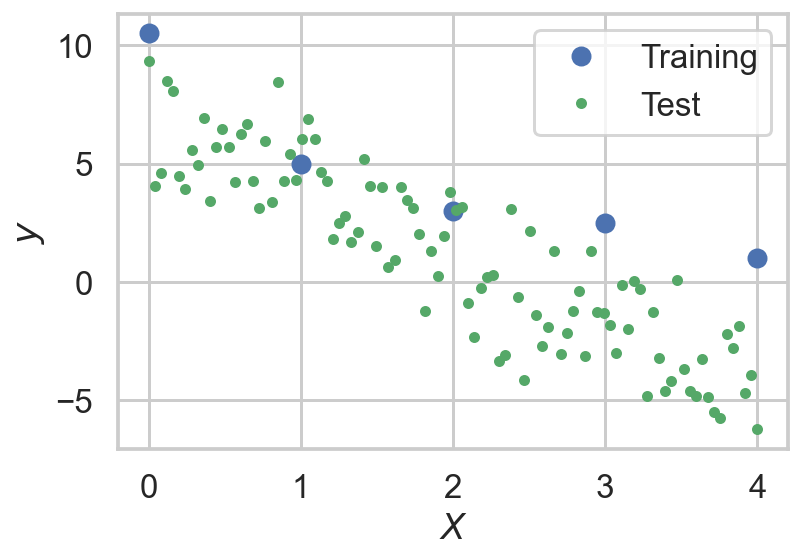

In [8]:
plt.plot(X[:, 0], y, 'bo', label='Training')
plt.plot(X_test[:, 0], y_test, "g.", label='Test')
plt.xlabel('$X$'); plt.ylabel('$y$'); plt.legend(frameon=True);

# Linear Regression Model

* We can express our constraints down with a **linear** model:

$$
y^{(i)} + \varepsilon^{(i)} =  \vec{x}^{(i)}\cdot \vec{w} + b, \forall i \in \{1,\ldots,m\}\,,
$$ 

where $\vec{w}$ and $b$ constitute a weight vector and $\varepsilon^{(n)} \sim \mathcal{N}(0, \sigma^2_\varepsilon)$.

* Weights are parameters of the linear model that can be tuned to fit the training data better.

A shorter version of this expression is the following equation:

$$\vec{y} + \vec{\epsilon} = \vec{X} \cdot \vec{w},\ \vec{X} \in \mathbb{R}^{m \times n},\ \vec{y} \in \mathbb{R}^m,\ \vec{\epsilon} \in \mathbb{R}^m,\ \vec{w} \in \mathbb{R}^n,$$

where the $i$-th **row** of $\vec{X}$ represents $\vec{x}^{(i)}$ and the $j$-th entry of the vector $\vec{y}$ represents $\vec{y}^{(j)}$.

* It might not be possible to find a weight vector that satisfies the constraints perfectly.
* Instead, we can minimize the sum of squared errors (SSE):

$$ \hat{\vec{w}} = \text{arg}\,\text{min}_\vec{w} \dfrac{1}{2}\left\|\vec{X}\vec{w} - \vec{y}\right\|^2_2,$$ 

where $\left\|\vec{A}\right\|_2$ is called [Frobenius norm](http://en.wikipedia.org/wiki/Matrix_norm#Frobenius_norm) and is the generalization of the Euclidean norm for matrices.

The *frequentist* *(maximum likelihood)* approach

* assumes that we first obtain observation training data, $\vec{y}$, and that the *best*  value of $\vec{w}$, is that which maximizes the likelihood function, $p(\vec{y}|\vec{x},\vec{w})$.

Under the Gaussian noise condition it can be shown that the maximum likelihood function for the training data is
$$
\begin{align}
p(\vec{y}|\vec{X},\vec{w},\sigma^2) & = \prod_{i=1}^m {\mathcal{N}\left(y^{(i)}\left|\vec{w}^\intercal\phi(\vec{x}^{(i)}),\sigma^2\right.\right)} \\
& =\frac{m}{2}\ln\left(\frac{1}{\sigma^2}\right) -\frac{m}{2}\ln(2\pi) - \frac{1}{2\sigma^2}\sum_{i=1}^m\left\{t_n -\vec{w}^\intercal\phi(\vec{x}^{(i)})\right\}^2\,,
\end{align}
$$ 
where $\vec{X}=\{\vec{x}^{(1)},\ldots,\vec{x}^{(m)}\}$ is the input value set for the corresponding $N$ observed output values contained in the vector $\mathbf{t}$, and $\mathcal{N}(\mu,\sigma^2)$ is the Normal Distribution (Gaussian).
    
Taking the logarithm of the maximum likelihood and setting the derivative with respect to $\vec{w}$ equal to zero, one can obtain the maximum likelihood parameters given by the **normal equations**:
$$\vec{w}_\text{ML} = \left(\vec{\Phi}^\intercal\vec{\Phi}\right)^{-1}\vec{\Phi}^\intercal\vec{y},$$ 
where $\vec{\Phi}$ is the $N \times M$ *design matrix* with elements $\Phi_{i,j}=\phi_j(\vec{x}^{(i)})$, and $\vec{y}$ is the $N \times K$
matrix of training set target values (for $K=1$, it is simply a column vector). 

Note that $\vec{\Phi}^\intercal$ is a $M \times N$ matrix, so that $\vec{w}_{ML}=\left(\vec{\Phi}^\intercal\vec{\Phi}\right)^{-1}\vec{\Phi}^\intercal\vec{y}$ is $(M \times N)\times(N \times M)\times(M\times N)\times(N \times K) = M \times K$, where $M$ is the number of free parameters and $K$ is the number of predicted 
target values for a given input.

Note that the only term in the likelihood function that depends on $\vec{w}$ is the last term. Thus, maximizing the likelihood function with respect to $\vec{w}$ *under the assumption of Gaussian noise* is equivalent to minimizing a 
sum-of-squares error function.

## Learning Weights

There are two ways to adjust the weights of a linear model (which includes linear models with nonlinear features):

#### Normal equations (analytical solution)

* Requires inversion of $m \times n$ matrix.
* It does not scale well with the number of features.

#### Gradient descent (iterative solution)

* Requires the calculation of $m$ gradients in each step.
* It does not scale well with the number of examples.

In addition, we can add a constraint to the objective function to penalize large weights: **Tikhonov regularization** (forward pointer).

## Normal Equations

Solving $\vec{X} \cdot \vec{w} = \vec{y}$ means solving
$$
\left\{
\begin{array}{rcrcl}
x^{(1)}_1 w_1 & + x^{(1)}_2 w_2 & + \cdots & + x^{(1)}_n w_n & = y^{(1)} \\
x^{(2)}_1 w_1 & + x^{(2)}_2 w_2 & + \cdots & + x^{(2)}_n w_n & = y^{(2)} \\
x^{(3)}_1 w_1 & + x^{(3)}_2 w_2 & + \cdots & + x^{(3)}_n w_n & = y^{(3)} \\
      \vdots  &          \vdots &   \ddots &          \vdots & = \vdots \\
x^{(m)}_1 w_1 & + x^{(m)}_2 w_2 & + \cdots & + x^{(m)}_n w_n & = y^{(m)}
\end{array}
\right.\,.
$$

* Frequently, solving equation $\vec{X} \cdot \vec{w} = \vec{y}$ directly for $\vec{w}$ by inversion is not viable.
* As $\vec{X}$ is not necessarily a square matrix, therefore $\vec{w} = \vec{X}^{-1} \vec{y}$ is usually not possible.
* This implies that it is usually impossible to find an exact solution.
* These systems are [overdetermined](https://en.wikipedia.org/wiki/Overdetermined_system).

*Note:* A system of equations is considered overdetermined if there are more equations than unknowns. An overdetermined system is almost always inconsistent (it has no solution) when constructed with random coefficients. However, an overdetermined system will have solutions in some cases, for example if some equation occurs several times in the system, or if some equations are linear combinations of the others.

### The linear [least squares](http://en.wikipedia.org/wiki/Linear_least_squares_%28mathematics%29) solution

* The linear least squares is the problem of approximately solving an overdetermined system of linear equations.
* The best approximation is defined as that which minimizes the sum of squared differences between the data values and their corresponding modeled values.


That is, the solution of 

$$\vec{X}^\intercal\vec{X} \hat{\boldsymbol{w}} = \vec{X}^\intercal\vec{y}$$

for $\hat{\boldsymbol{w}}$, i.e.,

$$\hat{\vec{w}} = (\vec{X}^\intercal\vec{X})^{-1}\vec{X}^\intercal\vec{y}.$$

The expression $(\vec{X}^\intercal\vec{X})^{-1}\vec{X}^\intercal$ is equivalent to the [Moore-Penrose pseudoinverse](http://en.wikipedia.org/wiki/Moore%E2%80%93Penrose_pseudoinverse) $\vec{X}^+$ of $\vec{X}$. It is a generalization of the inverse for non-square matrices. You can use this to implement normal equations if your library provides the function. You could also use a least squares solver (e.g. `numpy.linalg.lstsq`).

[Inversion of 2x2 matrices](https://en.wikipedia.org/wiki/Invertible_matrix#Inversion_of_2.C3.972_matrices):

$$\left(\begin{array}{cc}a & b\\ c & d\end{array}\right)^{-1} = \frac{1}{ad - bc}\left(\begin{array}{cc}d & -b\\ -c & a\end{array}\right)$$

* This approach is called linear least squares since the assumed function is linear in the parameters to be estimated. 
* Linear least squares problems are convex and have a closed-form solution that is unique, provided that the number of data points used for fitting equals or exceeds the number of unknown parameters, except in special degenerate situations. 
* In contrast, non-linear least squares problems generally must be solved by an iterative procedure, and the problems can be non-convex with multiple optima for the objective function. 
* If prior distributions are available, then even an underdetermined system can be solved using the Bayesian MMSE estimator.

See https://en.wikipedia.org/wiki/Linear_least_squares_(mathematics) for more details.

In [9]:
def normal_equations(X, y):
    w = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
    # ... or we can use the Moore-Penrose pseudoinverse (is usually more likely to 
    # be numerically stable)
    # w = np.linalg.pinv(X).dot(y)
    # ... or we use the solver
    # w = np.linalg.lstsq(X, y)[0]
    return w

### The bias trick

Add bias to each row/instance:

In [10]:
X_bias = np.hstack((X, np.ones((N, 1))))
X_test_bias = np.hstack((X_test, np.ones((N_test, 1))))

In [11]:
X.T

array([[0., 1., 2., 3., 4.]])

In [12]:
X_bias.T

array([[0., 1., 2., 3., 4.],
       [1., 1., 1., 1., 1.]])

In [13]:
w_norm = normal_equations(X_bias, y)

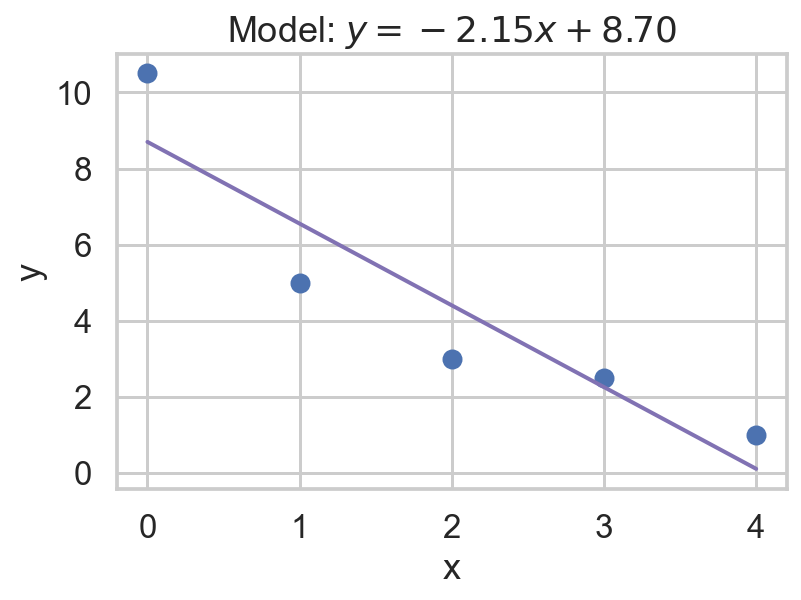

In [14]:
plt.plot(X_bias[:, 0], y, "o")
plt.plot(X_bias[:, 0], X_bias.dot(w_norm), "m-", linewidth=2)
plt.xlabel("x"); plt.ylabel("y"); plt.title("Model: $y = %.2f x + %.2f$" % tuple(w_norm));

We can now solve linear regression problems at will!

## Homework 1

Test the other forms of normal equations. 
* Check the numerical stability of each approach and 
* how long they take to compute.

## Computational cost and complexity

Think of this problem:
* inputs: 100 color images of size 256x256 pixels
* output: radius of the ball which is at the center of the image
* Is the direct solution via normal equations viable?

## Estimating problem tractability

Assuming that each pixel is represented by three bytes defining the RGB values:

In [15]:
n_pixels = 256 * 256
memory_size_xtx = n_pixels * n_pixels * 3 * 8
print("Required memory: %d GB" % (memory_size_xtx / 2**30))

Required memory: 96 GB


Inversion is an procedure that requires $O(n^{2.373})$ operations ([Source](http://en.wikipedia.org/wiki/Computational_complexity_of_mathematical_operations)).

# Gradient Descent

In cases where the training data set is very large or data is received in a stream, a direct solution using the normal equations may not be possible.

An alternative approach is the **stochastic gradient descent** algorithm.

Iteratively update the weights using the gradient as reference.
<div class="container-fluid">
  <div class="row">
      <div class="col-md-3"><span/></div>
      <div class="col-md-6">
              <img class='img-thumbnail' src='https://upload.wikimedia.org/wikipedia/commons/7/7a/Graph_of_sliding_derivative_line.gif'/>
      </div>
      <div class="col-md-3" align='center'><span/></div>
  </div>
</div>

$\Delta \vec{w}_t$ is minus the derivative of the error function $E(\vec{X}, \vec{y};\vec{w}_t)$ with respect to the weight $w_i$:

$$
\Delta w_i = - \alpha\frac{\partial E(\vec{X}, \vec{y};\vec{w})}{\partial w_i}\,,
$$

where:

* $\alpha$ is a hyperparameter called **learning rate**, it has to be set manually and must usually be within $\left(0, 1\right)$, typical values are $10^{-1}$, $10^{-2}$, $10^{-3}$, ...

Update $\vec{w}$ incrementally in every iteration $t$ as:

$$
\vec{w}(t+1) = \vec{w}(t) +  \Delta \vec{w}(t)\,,
$$



### Forward pointer

* Gradient descent actually is a more general rule.
* It can be applied to any minimization problem if the gradient can be computed.
* For example, artificial neural networks, support vector machines, $k$-means, etc.

## Gradient of the Linear Model

Using as error function the sum of squared errors (SSE),

$$E(\boldsymbol{X}, \boldsymbol{y};\boldsymbol{w}) = \frac{1}{2}\left\|\boldsymbol{X} \cdot \boldsymbol{w} - \boldsymbol{y}\right\|^2_2\,.$$

The gradient becomes

$$\nabla \boldsymbol{w} = \nabla_{\boldsymbol{w}} E(\boldsymbol{X}, \boldsymbol{y};\boldsymbol{w}) = \boldsymbol{X}^T \cdot (\boldsymbol{X} \cdot \boldsymbol{w} - \boldsymbol{y})\,.$$

## Implementing gradient descent

In [16]:
def error(X, y, w):
    return 0.5*np.linalg.norm(X.dot(w) - y)**2

In [17]:
def linear_regression_gradient(X, y, w):
    return X.T.dot(X.dot(w)-y)

## The learning loop

Initialize weights to small random values

In [18]:
w = np.random.random(2)/10000

In [19]:
alpha = 0.05

In [20]:
for i in range(50):
    # print('Iteration', i+1, 'weights', w, 'error', error(X_bias, y, w))
    w = w - alpha*linear_regression_gradient(X_bias, y, w)
print('w_norm:', w_norm, 'w grad. desc.', w)

w_norm: [-2.15  8.7 ] w grad. desc. [-2.089  8.526]


In [21]:
def plot_contour(X_data, y_data, bounds, resolution=50, cmap=cm.viridis, 
                 alpha=0.3, linewidth=5, rstride=1, cstride=5, ax=None):
    (minx,miny),(maxx,maxy) = bounds
    
    x_range = np.linspace(minx, maxx, num=resolution)
    y_range = np.linspace(miny, maxy, num=resolution)
    X, Y = np.meshgrid(x_range, y_range)
    
    Z = np.zeros((len(x_range), len(y_range)))
    
    for i, w_i in enumerate(x_range):
        for j, w_j in enumerate(y_range):
            Z[j,i] = error(X_data, y_data, [w_i, w_j])
    
    if not ax:
        fig = plt.figure(figsize=(6,6))
        ax = fig.gca()
        ax.set_aspect('equal')
        ax.autoscale(tight=True)
    cset = ax.contourf(X, Y, Z, 30, cmap=cmap, alpha=alpha)
    cset = ax.contour(X, Y, Z, 10, cmap=cmap)
    plt.clabel(cset, inline=1, fontsize=7)
    return Z

In [22]:
def plot_mesh(X_data, y_data, bounds, resolution=50, cmap=cm.viridis, 
                 alpha=0.3, linewidth=5, rstride=1, cstride=5):
    (minx,miny),(maxx,maxy) = bounds
    
    x_range = np.linspace(minx, maxx, num=resolution)
    y_range = np.linspace(miny, maxy, num=resolution)
    X, Y = np.meshgrid(x_range, y_range)
    
    Z = np.zeros((len(x_range), len(y_range)))
    
    for i, w_i in enumerate(x_range):
        for j, w_j in enumerate(y_range):
            Z[j,i] = error(X_data, y_data, [w_i, w_j])
    fig = plt.figure(figsize=(7,5))
    ax = fig.gca(projection='3d')
    
    ax.plot_surface(X, Y, Z, cmap=cmap, linewidth=1, antialiased=True, alpha=0.5)
    ax.plot_wireframe(X, Y, Z, rstride=10, cstride=10, cmap=cmap, linewidth=1, color='navy')
    return Z

## Visualizing the error surface

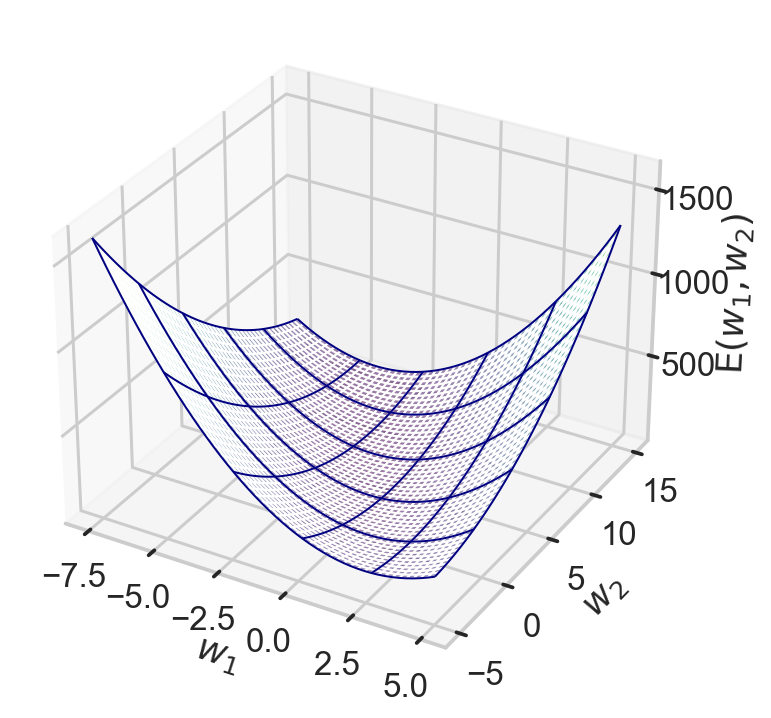

In [23]:
plot_mesh(X_bias, y, [[-7.5, -5], [5, 15]])
plt.setp(plt.gca(), xlabel='$w_1$', ylabel='$w_2$', zlabel='$\mathrm{E}(w_1,w_2)$')
plt.tight_layout()

In [24]:
def plot_gradients(X_data, y_data, bounds, resolution=100, cmap=cm.viridis, alpha=0.3, ax=None):
    (minx,miny),(maxx,maxy) = bounds
    
    x_range = np.linspace(minx, maxx, num=resolution)
    y_range = np.linspace(miny, maxy, num=resolution)
    
    X, Y = np.meshgrid(x_range, y_range)
    
    Z = np.zeros((len(x_range), len(y_range)))
    
    U = np.zeros((len(x_range), len(y_range)))
    V = np.zeros((len(x_range), len(y_range)))
    
    
    
    for i, w_i in enumerate(x_range):
        for j, w_j in enumerate(y_range):
            Z[j,i] = error(X_data, y_data, [w_i, w_j])
            g1, g2 = linear_regression_gradient(X_data, y_data, [w_i, w_j])
            U[j,i] = g1;  V[j,i] = g2
    
    speed = np.sqrt(U*U + V*V)
    
    if not ax:
        fig = plt.figure(figsize=(6,6))
        ax = fig.gca()
        
    cset = ax.contourf(X, Y, Z, 30, cmap=cmap, alpha=alpha)
    cset = ax.contour(X, Y, Z, 10, cmap=cmap, alpha=0.5)
    
    plt.clabel(cset, inline=1, fontsize=7)
    
    lw = 0.5+5.*speed/speed.max()
    
    ax.streamplot(X, Y, U, V, density=[0.75, 1], color='navy', linewidth=lw, arrowstyle='->')
    plt.tight_layout()

The gradients of the error with respect to the weights.

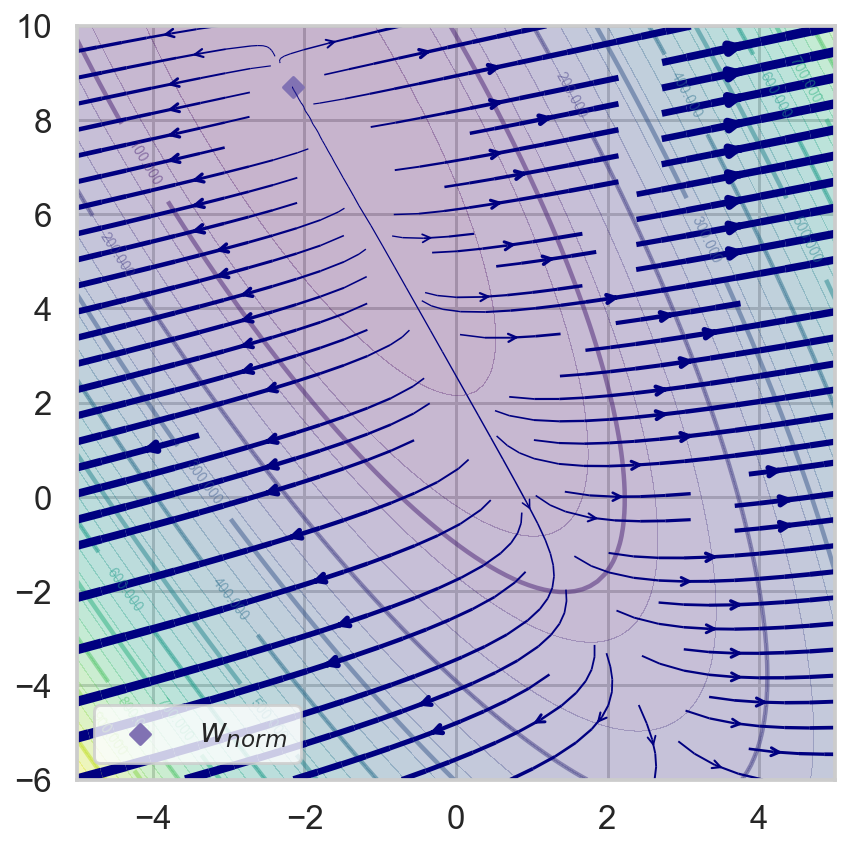

In [25]:
plot_gradients(X_bias, y, [[-5, -6], [5, 10]]);
plt.scatter(w_norm[0], w_norm[1], c='m', marker='D', s=50, label='$w_{norm}$')
plt.legend(frameon=True);

Implementing the gradient descent loop as a function.

In [26]:
def gradient_descent(X, y, w_0, alpha, max_iters):
    'Returns the values of the weights as learning took place.'
    w = np.array(w_0, dtype=np.float64)
    w_hist = np.zeros(shape=(max_iters+1, w.shape[0]))
    w_hist[0] = w
    for i in range(0,max_iters):
        delta_weights = -alpha*linear_regression_gradient(X_bias, y, w)
        w += delta_weights
        w_hist[i+1] = w
    return w_hist

In [27]:
w_0 = [-3,2] # we fix the initial weights to make it more illustrative
alpha = 0.05
max_iters = 25

In [28]:
w_hist = gradient_descent(X_bias, y, w_0, alpha, max_iters)

In [29]:
def plot_hist_contour(X_bias, y, w_hist, w_norm, ax=None, title=None, show_legend=False, show_labels=True):
    if not ax:
        fig = plt.figure(figsize=(5,5))
        ax = fig.gca()
    combi=np.hstack((w_norm.reshape(2,1), w_hist.T))
    bounds = (np.min(combi, axis=1)-2, np.max(combi, axis=1)+2)
    plot_contour(X_bias, y, bounds, ax=ax)
    ax.scatter(w_norm[0], w_norm[1], c='m', marker='D', s=50, label='$w_{norm}$')
    ax.plot(w_hist[:,0], w_hist[:,1], '.:', c='b')
    ax.scatter(w_hist[0,0], w_hist[0,1], c='navy', marker='o', s=65, label='start')
    ax.scatter(w_hist[-1,0], w_hist[-1,1], c='navy', marker='s', s=50, label='end')
    if show_labels:
        ax.set_xlabel('$w_1$')
        ax.set_ylabel('$w_2$')
    if title:
        ax.set_title(title)
    if show_legend:
        plt.legend(scatterpoints=1, bbox_to_anchor=(1.37,1), frameon=True);

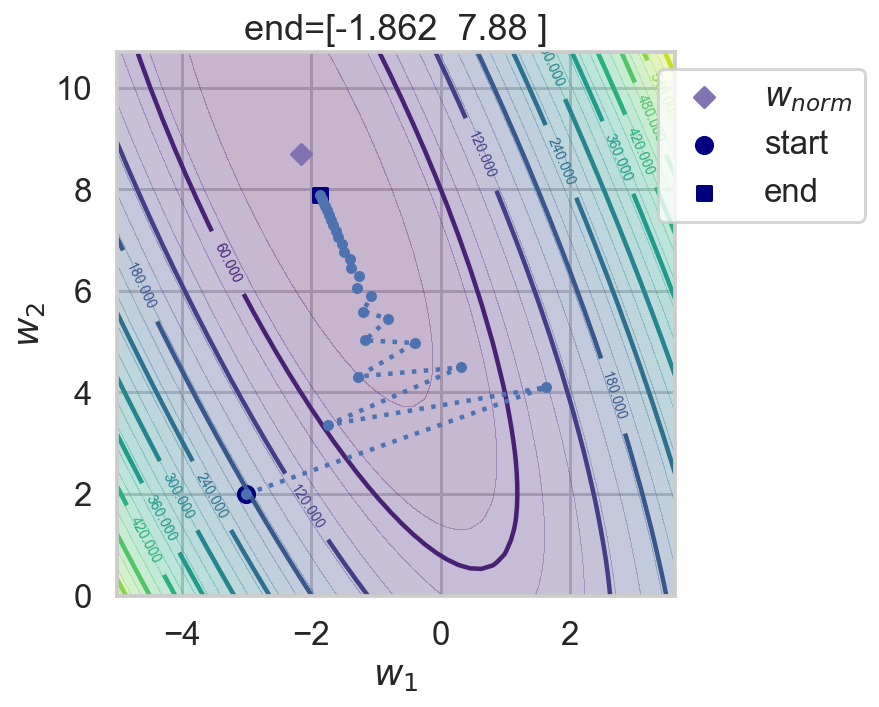

In [30]:
plot_hist_contour(X_bias, y, w_hist, w_norm, title='end={}'.format(w_hist[-1]), show_legend=True)

What is the impact of the learning rate ($\alpha$)?

In [31]:
def alphas_study(alphas):
    _, axs = plt.subplots(2, 3, figsize=(11,7), gridspec_kw={'height_ratios': [1,1]})
    axs = iter(chain(*axs))
    for alpha in alphas:
        w_hist = gradient_descent(X_bias, y , w_0, alpha, max_iters)
        plot_hist_contour(X_bias, y, w_hist, w_norm, ax=next(axs), title='$\\alpha='+str(alpha)+'$', show_labels=False) 
    plt.legend(scatterpoints=1, ncol=3, bbox_to_anchor=(-0.2,-0.2), frameon=True)

## Impact of learning rate

In [32]:
alphas = np.linspace(0.02,0.07,6)
alphas

array([0.02, 0.03, 0.04, 0.05, 0.06, 0.07])

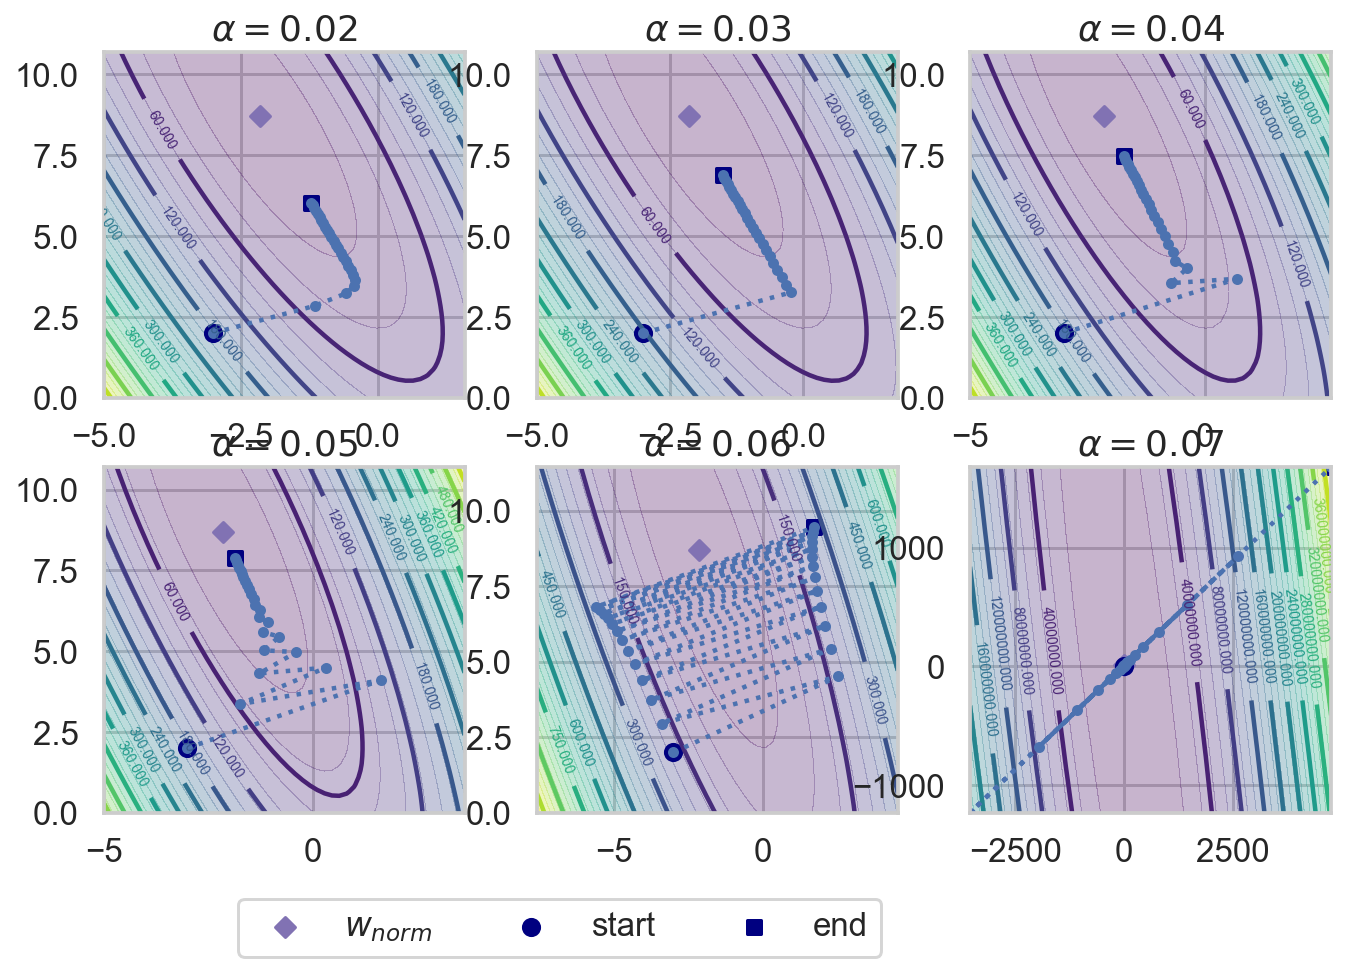

In [33]:
alphas_study(alphas)

### Improving GD by adding a *momentum* term

Idea adding some an inertial momentum to the process can:
* accelerate convergence when moving in a plateau, or
* damp oscilations.

Update $\vec{w}$ incrementally in every iteration $t$ as:

$$\vec{w}(t+1) = \vec{w}(t) + \alpha\Delta \vec{w}(t) + \beta \Delta \vec{w}(t-1),$$

where $\beta\in\mathbb{R}^+$ is known as the momentum rate.

In [34]:
def gradient_descent_with_momentum(X, y, w_0, alpha, beta, max_iters):
    w = np.array(w_0, dtype=np.float64)
    w_hist = np.zeros(shape=(max_iters+1, w.shape[0]))
    w_hist[0] = w
    omega = np.zeros_like(w)
    for i in range(max_iters): 
        delta_weights = -alpha*linear_regression_gradient(X, y, w) + beta*omega
        omega = delta_weights
        w += delta_weights
        w_hist[i+1] = w
    return w_hist

In [35]:
alpha = 0.05
beta = 0.5
max_iters = 25

In [36]:
w_hist = gradient_descent(X_bias, y, (-3,2), alpha, max_iters)
w_hist_mom = gradient_descent_with_momentum(X_bias,y, (-3,2), alpha, beta, max_iters)

In [37]:
def comparison_plot():
    fig = plt.figure(figsize=(9,4.5))
    ax = fig.add_subplot(121)
    plot_hist_contour(X_bias, y, w_hist, w_norm, ax=ax, title='Gradient descent')
    ax = fig.add_subplot(122)
    plot_hist_contour(X_bias, y, w_hist_mom, w_norm, ax=ax, title='Gradient descent with momentum', show_legend=True) 
    plt.tight_layout()

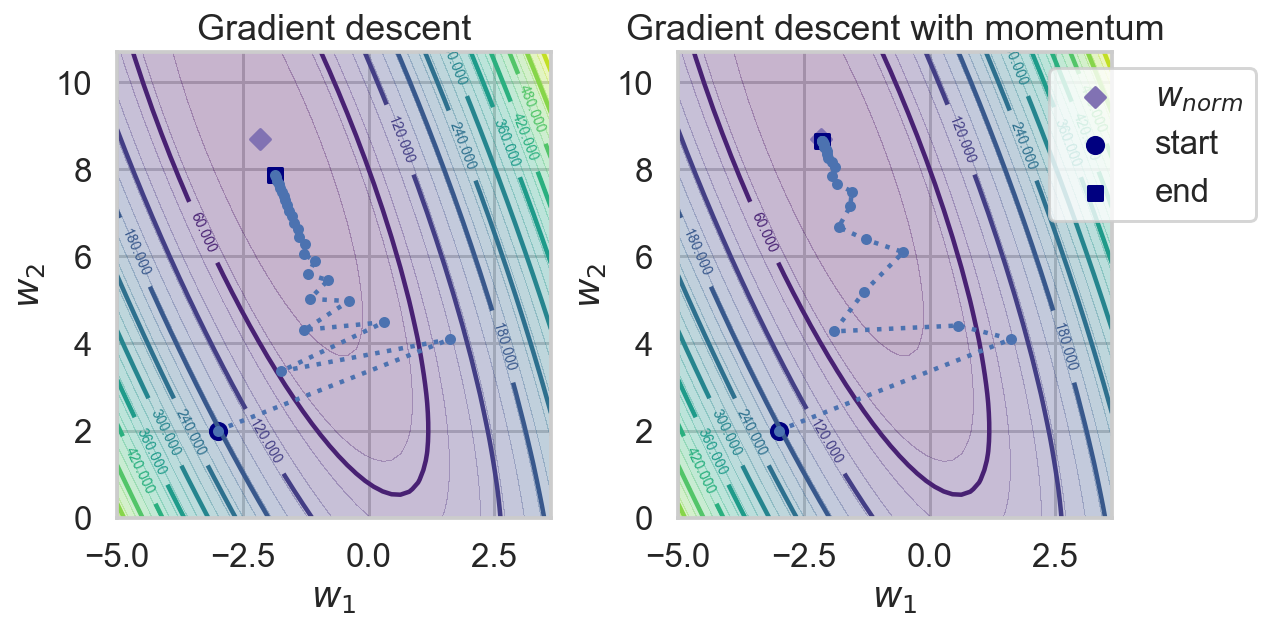

In [38]:
comparison_plot()

In [39]:
def alphas_study_with_momentum(alphas, beta):
    _, axs = plt.subplots(2, 3, figsize=(11,7), gridspec_kw={'height_ratios': [1,1]})
    axs = iter(chain(*axs))
    for alpha in alphas:
        w_hist = gradient_descent_with_momentum(X_bias, y, w_0, alpha, beta, max_iters)
        plot_hist_contour(X_bias, y, w_hist, w_norm, ax=next(axs), title='$\\alpha='+str(alpha)+'$', show_labels=False)  
    plt.legend(scatterpoints=1, ncol=3, bbox_to_anchor=(-0.2,-0.2), frameon=True);

## Impact of the momentum term

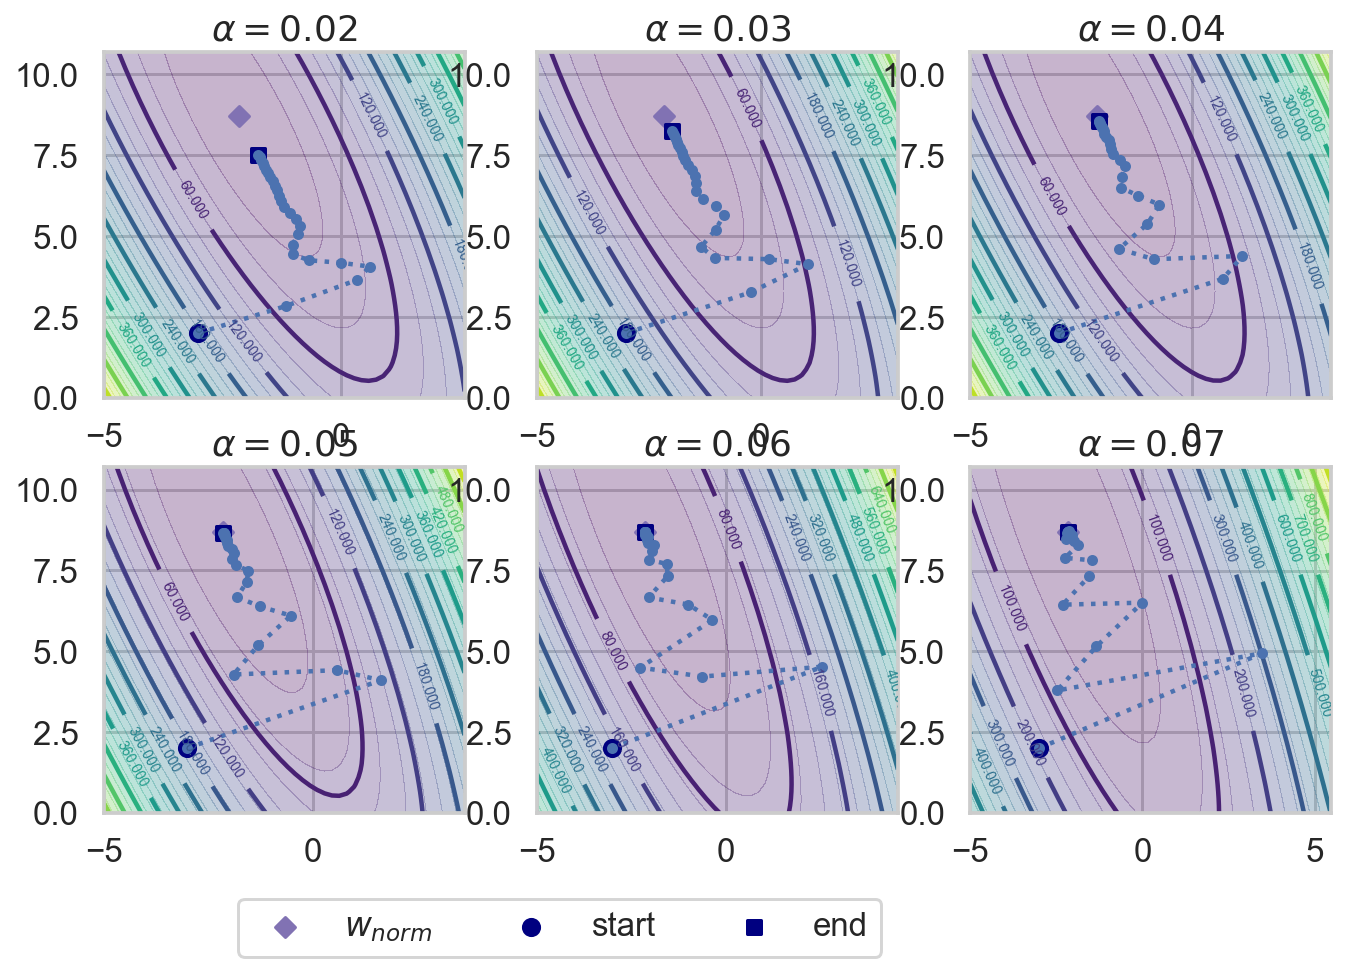

In [40]:
alphas_study_with_momentum(alphas, 0.5)

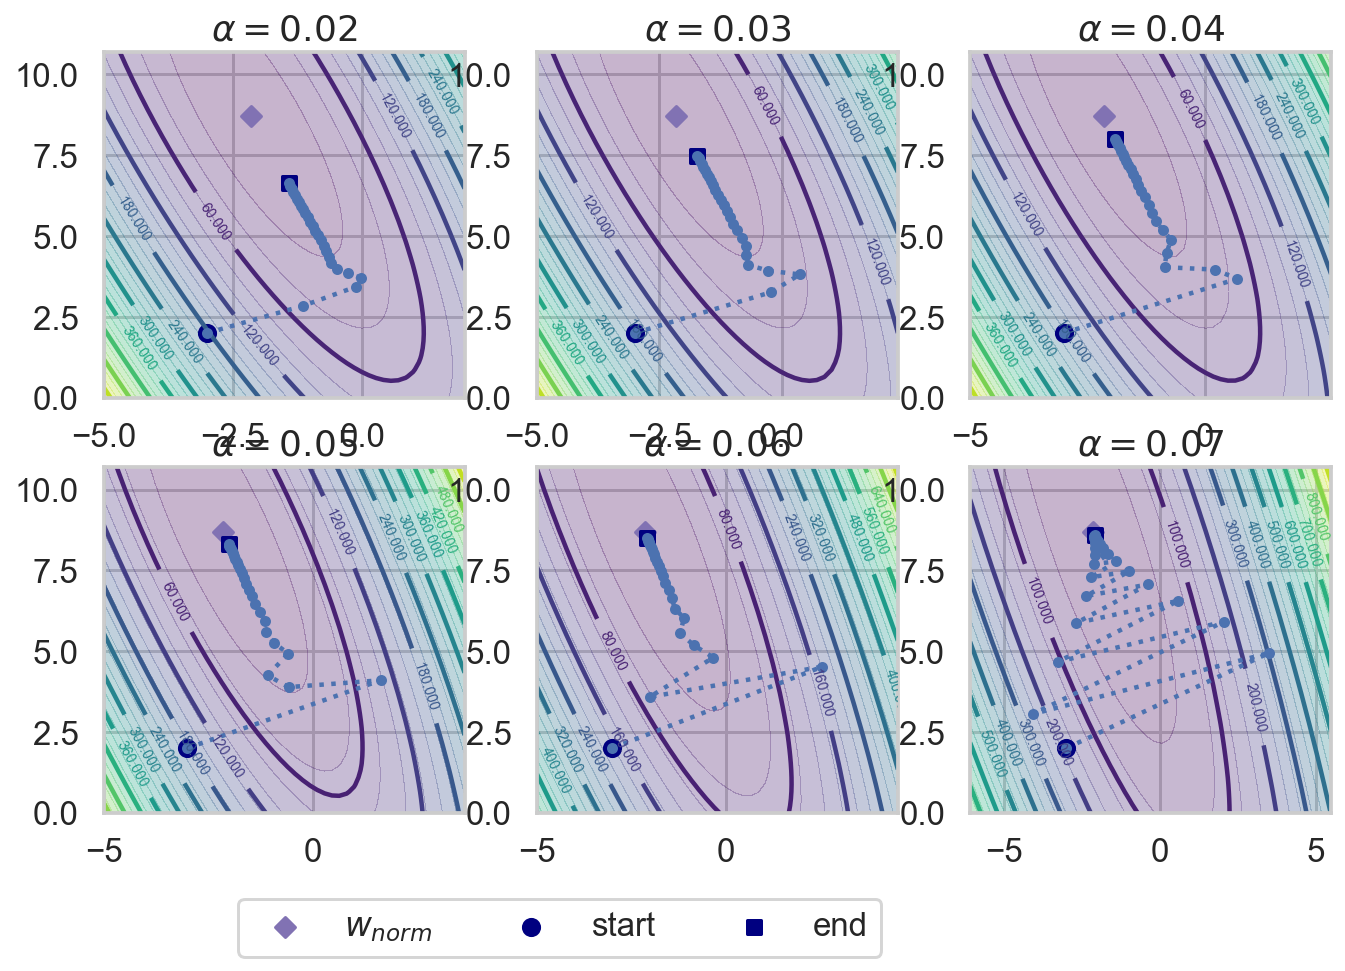

In [41]:
alphas_study_with_momentum(alphas, 0.25)

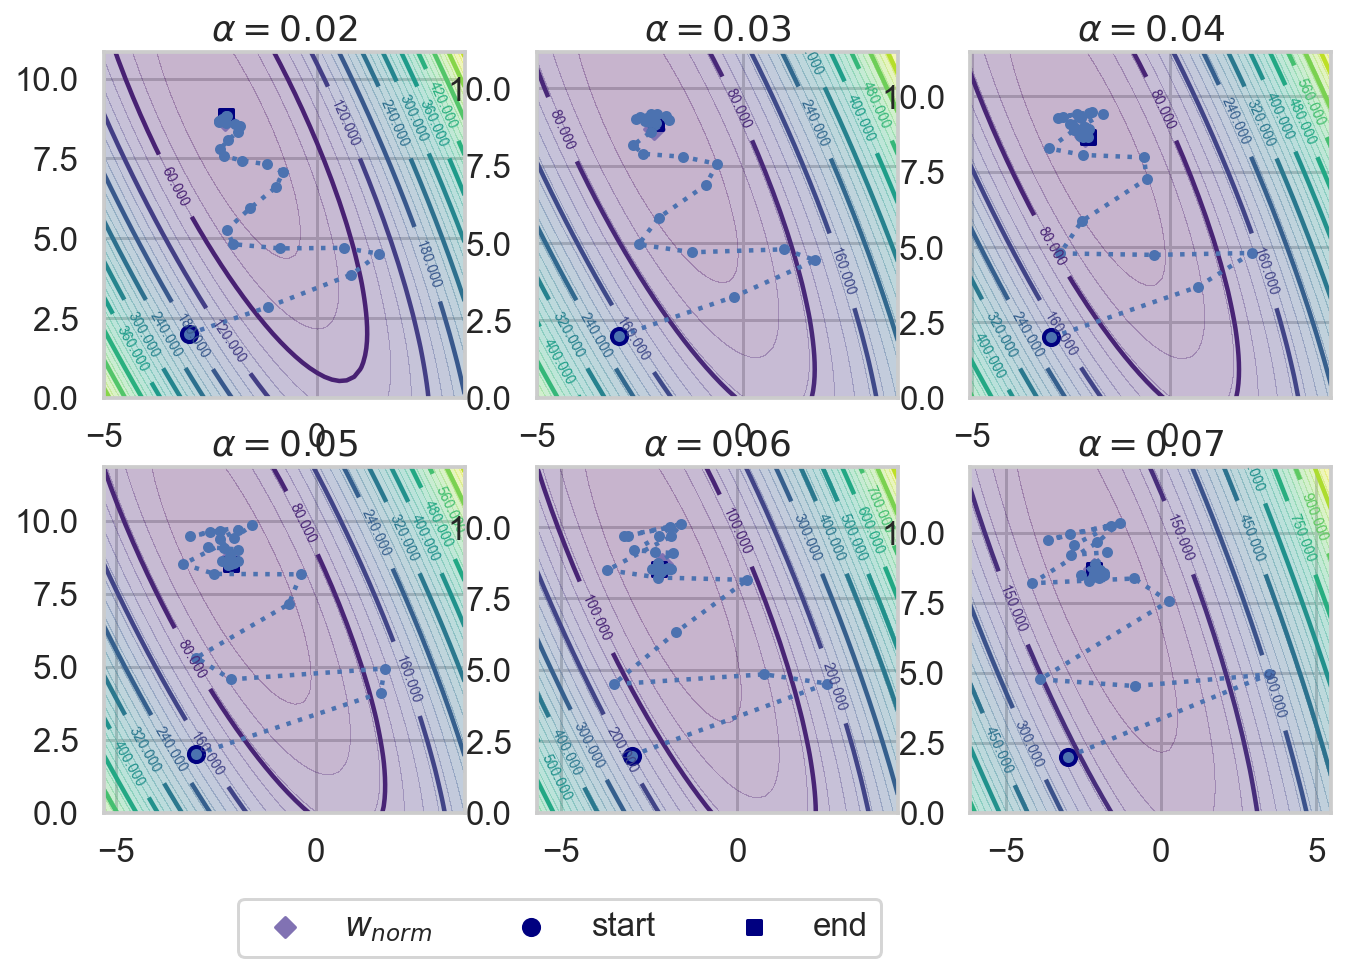

In [42]:
alphas_study_with_momentum(alphas, 0.75)

... I know you are wondering how $\beta=1$ looks like.

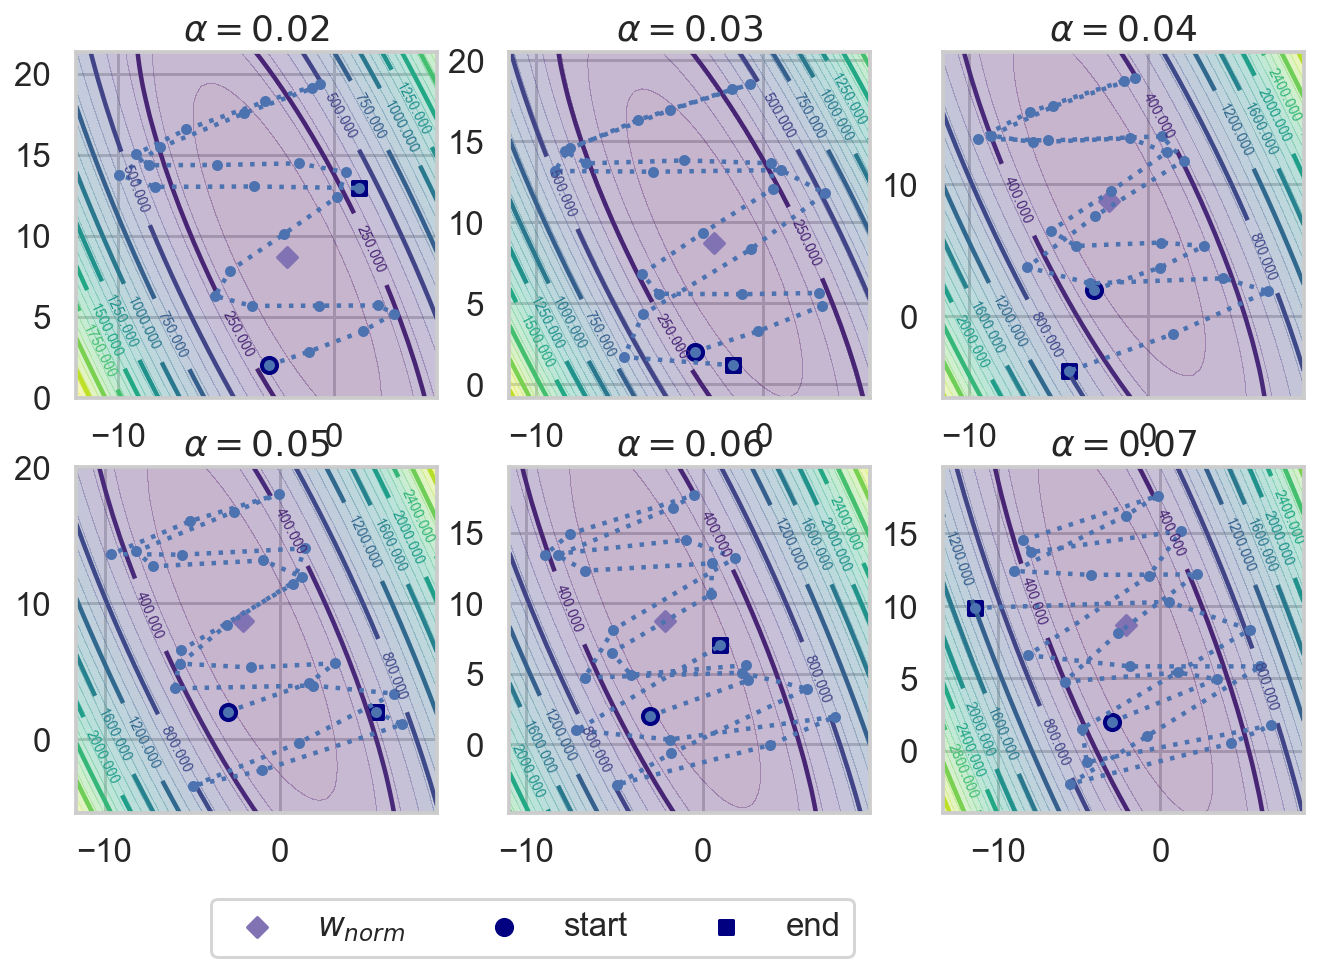

In [43]:
alphas_study_with_momentum(alphas, 1.05)

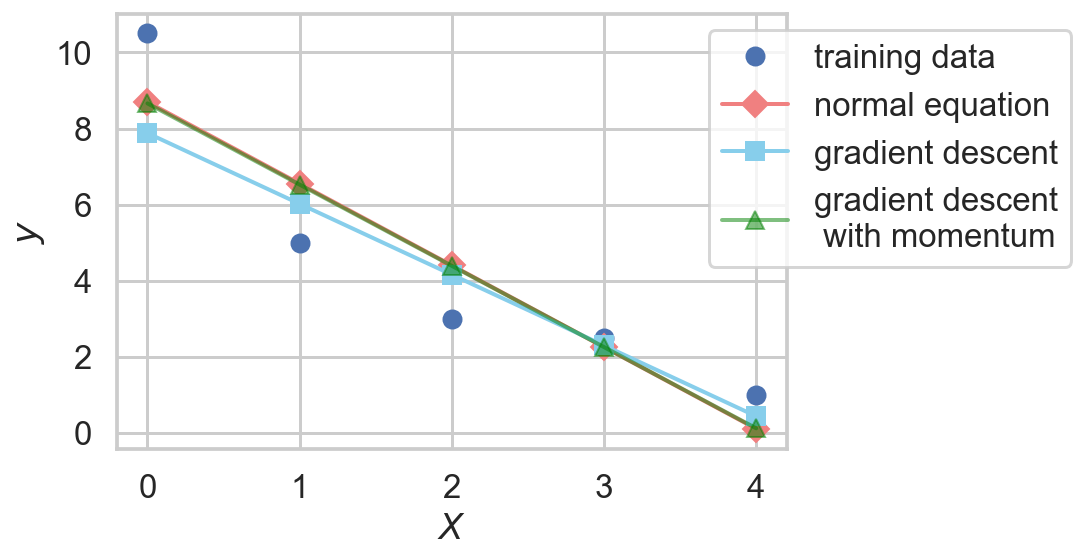

In [44]:
plt.plot(X_bias[:, 0], y, "o", label='training data')
plt.plot(X_bias[:, 0], X_bias.dot(w_norm), "D-", c='lightcoral',  
         linewidth=2, label='normal equation')
plt.plot(X_bias[:, 0], X_bias.dot(w_hist[-1]), "s-", c='skyblue', 
         linewidth=2, label='gradient descent')
plt.plot(X_bias[:, 0], X_bias.dot(w_hist_mom[-1]), "^-", c='green', 
         linewidth=2, alpha=0.5, label='gradient descent\n with momentum')
plt.xlabel("$X$"); plt.ylabel("$y$"); plt.legend(numpoints=1, bbox_to_anchor=(1.45,1), frameon=True);

## Normal equations vs gradient descent

In [45]:
N_test = 10000000
X_test_load = np.linspace(0.0, 4.0, N_test).reshape((N_test, 1))
y_test_load = np.linspace(7.0, -5.0, N_test)+ 2*np.random.randn(N_test)
X_test_load_bias = np.hstack((X_test_load, np.ones((N_test, 1))))

In [46]:
%%time 
w_norm = normal_equations(X_test_load_bias, y_test_load)

CPU times: user 184 ms, sys: 116 ms, total: 300 ms
Wall time: 250 ms


In [47]:
%%time 
w_grad = gradient_descent_with_momentum(X_test_load_bias, y_test_load, 
                                              np.random.random(2)/1000, 0.000001, 0.25, 25)

CPU times: user 2.44 s, sys: 1.24 s, total: 3.68 s
Wall time: 1.41 s


### Comparing results

In [48]:
w_norm

array([-3.   ,  7.001])

In [49]:
w_grad[-1]

array([-6.269e+43, -2.451e+43])

In [50]:
np.linalg.norm(w_norm - w_grad[-1])

6.731111709084492e+43

## Homework 2

* Why don't we always choose a very small learning rate?
* Your implementation of gradient descent oscillates between two error values. What could be the cause?

## You said we were going to be using `scikit-learn`

In [51]:
from sklearn.linear_model import LinearRegression

```python
# choose the model Hyperparameters
model = LinearRegression(fit_intercept=True)

# fit the model to the data
model.fit(X, y)
```

## Can we make linear models non-linear?

* Nonlinear projection of features (e.g. polynomial regression)
* Kernel trick (e.g. SVR, SVM, ...)
* Mixture of experts (e.g. locally weighted regression, locally weighted projection regression, Gaussian mixture regression, ...)
* Learn nonlinear features (e.g. artificial neural networks)

## Approximation of nonlinear functions (with a linear model)

* To approximate nonlinear functions with a linear model, we have to generate **nonlinear features**. 

* In this example, we generate **cosinusoidal** features. You could also try radial basis functions, polynomials, ...

* We expand each feature $x_j$ to the nonlinear feature vector 

$$\left\langle\cos(\frac{0}{d} \pi x_j), \cos(\frac{1}{d} \pi x_j), \ldots, \cos(\frac{d}{d} \pi x_j)\right\rangle^\intercal\,,$$ 

where $d$ is the number of basis functions. 

* Note that $\cos \left(\frac{0}{d} \pi x_j \right)=1$ is the bias we added manually in the previous example.

In [52]:
from itertools import chain, cycle

In [53]:
def cosinusoidalize(X, n_degree):
    X_cosinusoidal = np.ndarray((len(X), n_degree+1))
    for d in range(n_degree+1):
        X_cosinusoidal[:, d] = np.cos(X[:, 0] * np.pi * d / n_degree)
    return X_cosinusoidal

In [54]:
# Utility function
def build_cosinusoidal(n_degree, w):
    return ((("%+.2f \\cos(\\frac{%d \\pi x}{" + str(n_degree) + "} )") * (n_degree + 1)) % tuple(chain(*zip(w, range(n_degree + 1)))))

In [55]:
N_DEGREE = 4

In [56]:
X_cosinusoidal = cosinusoidalize(X, n_degree=N_DEGREE)
X_test_cosinusoidal = cosinusoidalize(X_test, n_degree=N_DEGREE)

In [57]:
X.T, X_cosinusoidal

(array([[0., 1., 2., 3., 4.]]),
 array([[ 1.   ,  1.   ,  1.   ,  1.   ,  1.   ],
        [ 1.   ,  0.707,  0.   , -0.707, -1.   ],
        [ 1.   ,  0.   , -1.   , -0.   ,  1.   ],
        [ 1.   , -0.707, -0.   ,  0.707, -1.   ],
        [ 1.   , -1.   ,  1.   , -1.   ,  1.   ]]))

### What is the effect of the basis transformation?

In [58]:
from matplotlib.lines import lineStyles

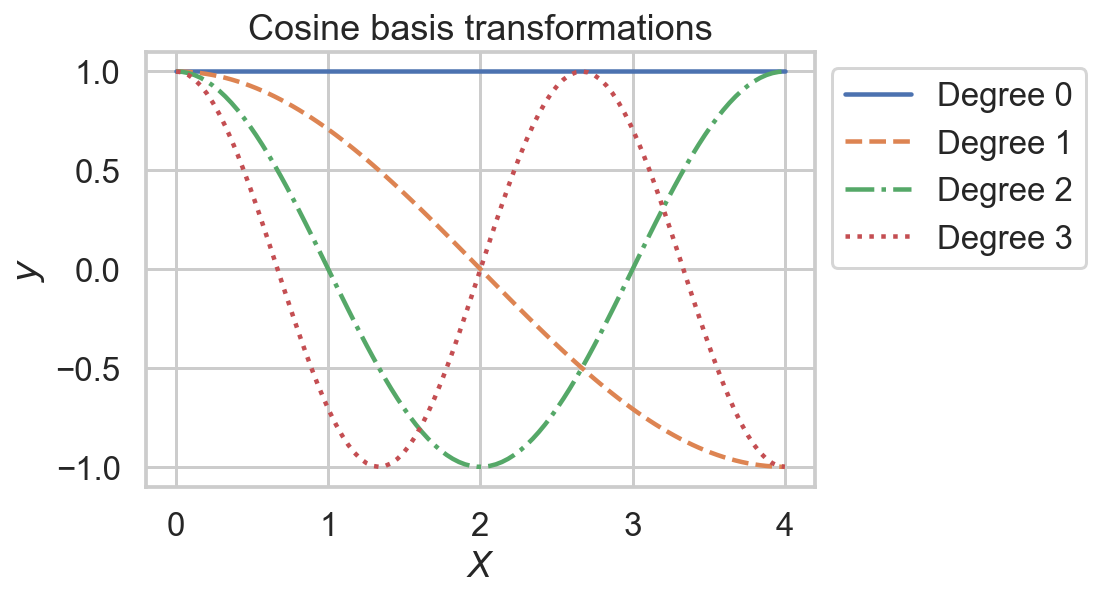

In [59]:
ls = cycle([style for style in lineStyles if not lineStyles[style] =='_draw_nothing'])
for deg in range(N_DEGREE):
    plt.plot(np.linspace(0,4,100), X_test_cosinusoidal[:,deg], 
             linestyle=next(ls), label='Degree '+str(deg))
plt.legend(frameon=True, bbox_to_anchor=(1.,1))
plt.title('Cosine basis transformations'); plt.xlabel("$X$"); plt.ylabel("$y$"); 

In [60]:
w_cos = normal_equations(X_cosinusoidal, y)

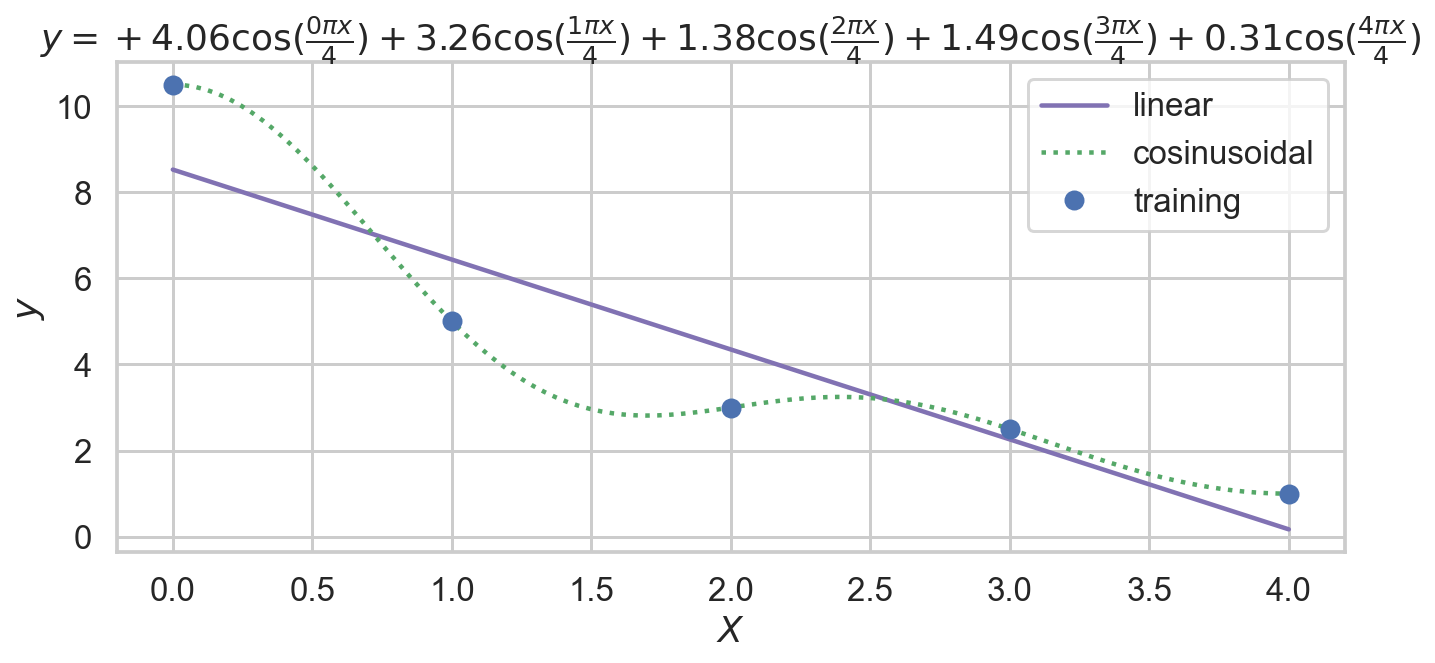

In [61]:
plt.figure(figsize=(11,4.5))
plt.plot(X_bias[:, 0], X_bias.dot(w), "m-", label='linear')
plt.plot(X_test_bias[:, 0], X_test_cosinusoidal.dot(w_cos), "g:", label='cosinusoidal')
plt.plot(X_bias[:, 0], y, "bo", label='training')
plt.xlabel("$X$"); plt.ylabel("$y$"); plt.legend(frameon=True)
plt.title("$y = " + build_cosinusoidal(N_DEGREE, w_cos) + "$");

You might be wondering, is this cheating? 
* I am hand-picking basis functions.
* This approach has little applicability in real-world practice but...
* ...hints us towards an interesting direction.

# Homework 3

* What happens if you change the basis transformation to 

$$\left\langle\sin(\frac{0}{d} \pi x_j), \sin(\frac{1}{d} \pi x_j), \ldots, \sin(\frac{d}{d} \pi x_j)\right\rangle^\intercal\,,$$

for $d$=`N_DEGREES`=4?

* How it can be improved?

# How can we make a model more general?

* **Get more training data.**
* Generate artificial training data:
    * Add noise to your training data
    * Example for object recognition: scale, rotate, distort images, select random samples from a bigger image, corrupt image, ...
* Prefer simple models (e.g. degree of polynomial)
* Penalize large weights, for example
    * quadratic values of weights
    * absolute values of weights
    * ...
* Average **different** models (ensemble methods)

# Over and Under Fitting
Techniques used to account for over fitting or under fitting a given model when using a maximum likelihood approach.

## Regularized Least Squares
* Regularization attempts to address the problem of overfitting a given model to the training data and/or eliminating parameters that are not important based on the data. 
* The general total error function with a **regularization term** is given by

$$
E_D(\vec{w}) + \lambda E_W(\vec{w})\,.
$$

where $\lambda$ is the regularization coefficient and $E_W$ is the regularization term.

A commonly used regularization term is the sum-of-squares of the model parameters,

$$E_W(\vec{w}) = \frac1{2}\vec{w}^\intercal\vec{w}\,,$$

known as the **weight decay** regularizer. 

This regularization terms leads to the optimal solution, assuming a linear regression model with Gaussian noise on the training data, of 

$$
\vec{w} = \left(\lambda \vec{I} + \vec{\Phi}^\intercal \vec{\Phi}\right)^{-1} \vec{\Phi}^T\vec{y}\,.
$$

In [62]:
def y(x, m, b, mu=0, sigma=1):
    return m * x + b + np.random.normal(mu, sigma, 1)[0]

In [63]:
def el_pow(x, pow):
    temp = x
    for i in range(pow - 1):
        temp = temp * x
    return temp

In [64]:
def prediction(params, x):
    pred = 0
    for i in range(len(params)):
        pred += params[i] * math.pow(x, i)
    return pred

Generating training data, with $N$ data points

In [65]:
N = 101
M = 8

In [66]:
t = np.empty(N)
domain = np.empty(N)
domain_bound = 1.0 / N
for i in range(N):
    domain[i] = i * domain_bound
for i in range(N):
    t[i] = y(x=domain[i], m=4.89, b=0.57)

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


Find the solution without using regularization design matrix, $\phi$, of dimension $N\times M$.

In [67]:
phi = np.array([np.ones(N), domain, el_pow(domain,2), el_pow(domain,3),
                el_pow(domain,4), el_pow(domain,5), el_pow(domain,6),el_pow(domain,7)]).T
temp1 = np.linalg.inv(np.dot(phi.T,phi)) #inverse of phi.T X phi
temp2 = np.dot(temp1, phi.T)

Solution without regularization:

In [68]:
w_nreg = np.dot(temp2,t)

In [69]:
w_nreg

array([   -0.553,    36.451,  -399.81 ,  2045.107, -5057.45 ,  6491.158,
       -4177.106,  1067.635])

In [70]:
predicted_t = [prediction(w_nreg,x) for x in domain]

Finding the regularized solution

In [71]:
lam = 0.1
temp1 = np.linalg.inv(lam * np.eye(M) + np.dot(phi.T, phi))
temp2 = np.dot(temp1, phi.T)
w_reg = np.dot(temp2, t)

In [72]:
w_reg

array([ 0.048,  5.33 ,  1.226, -0.734, -1.026, -0.549,  0.157,  0.846])

In [73]:
predicted_t_reg = [prediction(w_reg, x) for x in domain]

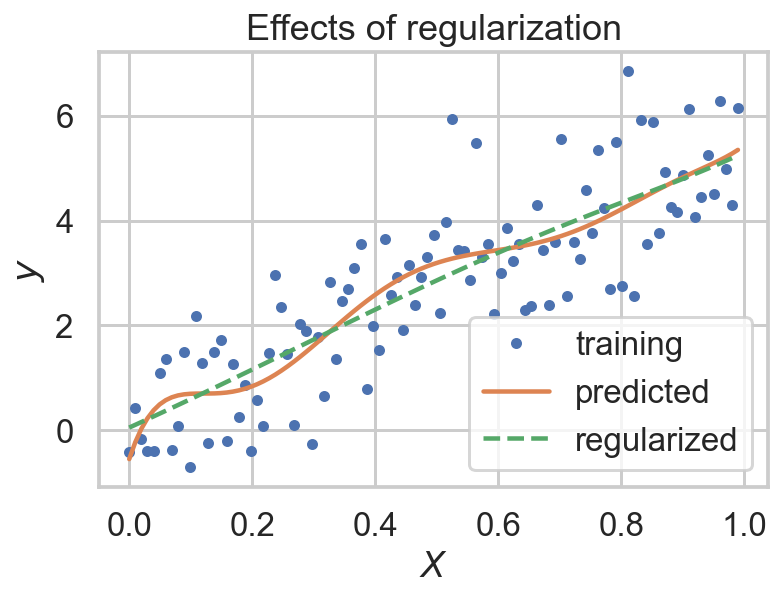

In [74]:
plt.plot(domain, t, '.', label='training')
plt.plot(domain, predicted_t, label='predicted')
plt.plot(domain, predicted_t_reg, '--', label='regularized')
plt.legend(loc='lower right', frameon=True); plt.xlabel("$X$"); plt.ylabel("$y$")
plt.title('Effects of regularization');

# Final remarks

* We now have a tool for solving regression problems.
* ...but the world is highly non-linear 😱.
* Gradient descent is applicable in cases where the loss function is differentiable with respect to the parameters.
* We saw regularization in action for the first time.
* Read Chapter 3 of Hastie, Tibshirani and Friedman (2009) [The Elements of Statistical Learning (2nd edition)](http://statweb.stanford.edu/~tibs/ElemStatLearn/) Springer-Verlag.

<hr/>
<div class="container-fluid">
      <div class="row">
          <div class="col-md-3" align='center'>
              <img align='center' alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png"/>
          </div>
          <div class="col-md-9">
              This work is licensed under a [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License](http://creativecommons.org/licenses/by-nc-sa/4.0/).
          </div>
      </div>
</div>

In [75]:
# this code is here for cosmetic reasons
from IPython.core.display import HTML
from urllib.request import urlopen
HTML(urlopen('https://raw.githubusercontent.com/lmarti/jupyter_custom/master/custom.include').read().decode('utf-8'))

---